#### **Welcome to Programming Assignment 5 on Deep Learning for Computer Vision.**
This assignment is based on the content you learned in Week-11 of course.

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Week 11

**Cycle-GAN**

In this assignment we will implement a Cycle-GAN. Please refer to the lecture and the following paper: https://arxiv.org/abs/1703.10593 for an understanding of how Cycle-GAN works.


In [ ]:
import math
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import random
import os
import numpy as np
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import itertools

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
# Please do not modify anything in this cell

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(0)

In [ ]:
# Please do not modify anything in this cell

def show_images(images):
    images = torch.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

In [ ]:
# Please do not modify anything in this cell

dtype = torch.float

# set device

device = torch.device("cuda:0")

**Preparing the data**

Cycle-GAN is used to translate data from a source domain to a target domain using unpaired samples from both domains. For this implementation we will consider the problem of translating from the usual MNIST images(bright digits with dark background) to their negatives(dark digits in bright background). Although this is a simple translation that can be achieved by pixed value inversion, it will highlight the working principle of Cycle-GAN. We will prepare the target domain data by manually applying the transformation to the regular MNIST data. Note that the generated data does not have a direct mapping between the images in the source domain and their counter parts in the target domain.

download MNIST if not exist


100%|██████████| 9912422/9912422 [00:00<00:00, 117070489.57it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42593422.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19124642.30it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19340638.34it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



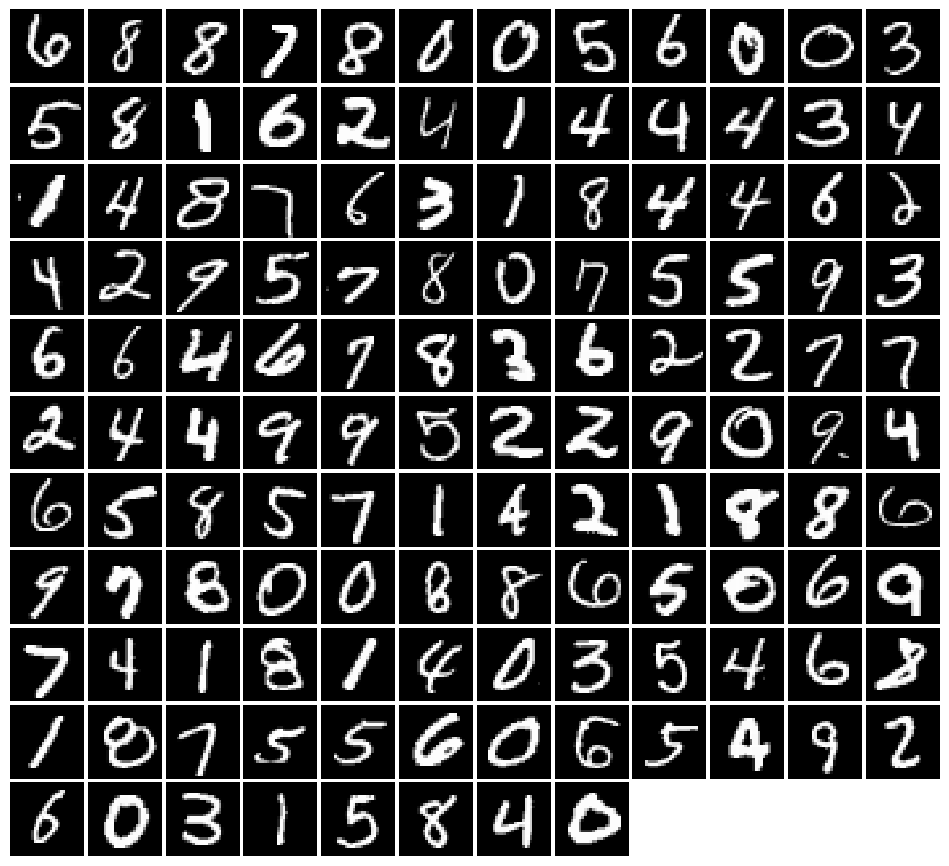

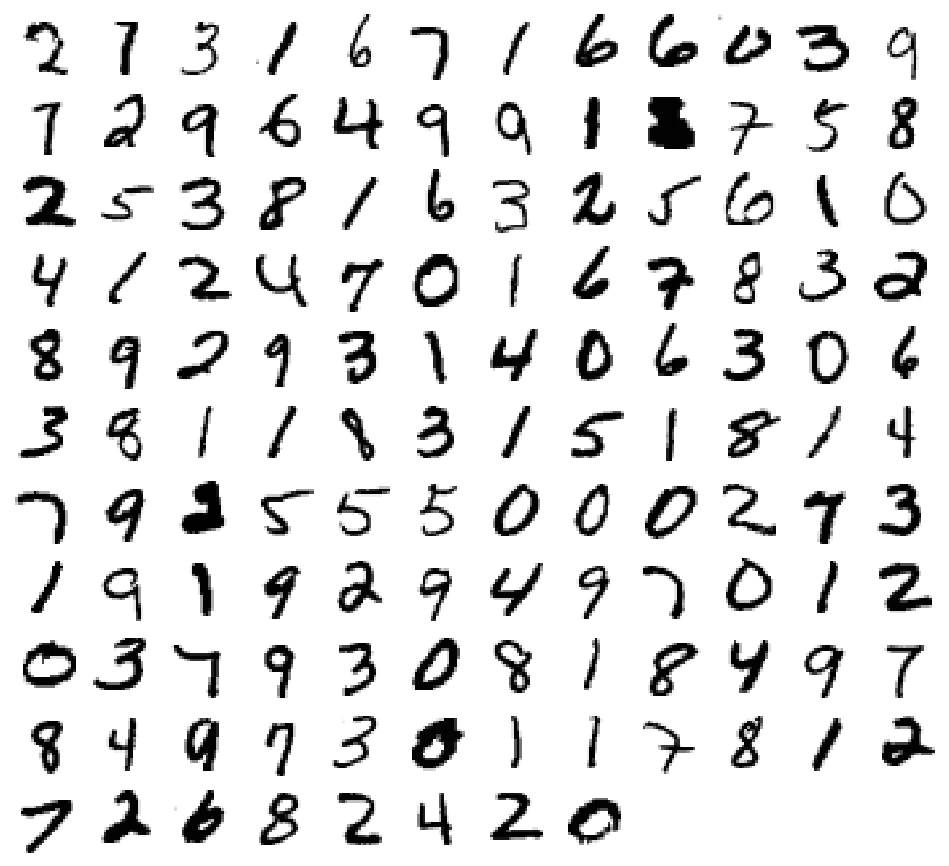

In [ ]:
# Please do not modify anything in this cell

# let us load the input images from the dataset and visualize some images!

batch_size = 128

print('download MNIST if not exist')

transform_A = T.Compose([
        T.ToTensor(), # convert the image to a pytorch tensor
        ])

transform_B = T.Compose([
        T.ToTensor(), # convert the image to a pytorch tensor
        lambda x: T.functional.invert(x) # convert images to their negatives
        ])


# source domain data denoted by domain A
mnist_A_train = dset.MNIST('./data', train=True, download=True,
                       transform=transform_A)

loader_A_train = DataLoader(mnist_A_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


# target domain data denoted by doamin B
mnist_B_train = dset.MNIST('./data', train=True, download=True,
                       transform=transform_B)

loader_B_train = DataLoader(mnist_B_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


imgs_A = next(iter(loader_A_train))[0].view(batch_size, 784)
imgs_B = next(iter(loader_B_train))[0].view(batch_size, 784)

show_images(imgs_A)
show_images(imgs_B)


**Generator and Discriminator**

Our Cycle-GAN implementation will contain 2 instances of generators and 1 instance of a discriminator with the following architecture.

**Discriminator**

The architecture is:
 * Flatten (Hint: nn.Flatten())
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1 (no activation at output)
  
The output of the discriminator is of shape `[batch_size, 1]`, and contains real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

**Generator**

The architecture is:
 * Fully connected layer from 784 to 128
 * `ReLU`
 * Fully connected layer from 128 to 784
 * `TanH` (to clip the image to be in the range of [-1,1])

We will be creating two instances of this generator to go from domain A to B and from B to A respectively. The output of the generators are of shape `[batch_size, 784]`.

In [ ]:

def discriminator():

  #### YOUR CODE STARTS HERE ####

  # Implement a PyTorch nn.Sequential model for the discriminator architecture given above

  model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),  # 1st Fully-Connected layer.
    nn.LeakyReLU(0.01),
    nn.Linear(256, 256),  # 2nd Fully-Connected layer.
    nn.LeakyReLU(0.01),
    nn.Linear(256, 1)     # 3rd Fully-Connected layer.
  )

  #### YOUR CODE ENDS HERE ####

  return model


def generator():

  #### YOUR CODE STARTS HERE ####

  # Implement a PyTorch nn.Sequential model for the generator architecture given above

  model = nn.Sequential(
    nn.Linear(784, 128),  # 1st Fully-Connected layer.
    nn.ReLU(),
    nn.Linear(128, 784),        # Hidden layer.
    nn.Tanh()
  )

  #### YOUR CODE ENDS HERE ####

  return model

**Loss functions**

Cycle-GAN involves the generator, discriminator and the cyclic loss. Please refer to the lecture for detailed explanations.

The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
The discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
The cyclic loss is:
$$ \ell_C = -\mathbb{E}_{x \sim p_\text{data}}\left||G_{YX}(G_{XY}(x)- x\right||$$
We will be *minimizing* these losses. We have already implemented the functions to compute generator and discriminator losses. Please go trhough them carefully. You need to write the function for cyclic loss.

In [ ]:
def discriminator_loss(logits_real, logits_fake):
  """
  Computes the discriminator loss described above.

  Inputs:
  - logits_real: PyTorch Tensor of shape (batch_size, 1) giving scores for the real data.
  - logits_fake: PyTorch Tensor of shape (batch_size, 1) giving scores for the fake data.

  Returns:
  - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
  """
  loss = None

  # For the discriminator (D), the true target (y = 1) corresponds to "real" images.
  # Thus, for the scores of real images, the target is always 1 (a vector).
  real_labels = torch.ones_like(logits_real, device=device)
  # Compute the BCE for the scores of the real images.
  # Note that the BCE itself uses the Expectation formula (in addition, an average is
  # taken throughout the losses, not a sum [as requested in this assignment]).
  real_loss = F.binary_cross_entropy_with_logits(logits_real, real_labels)

  # For D, the false target (y = 0) corresponds to "fake" images.
  # Thus, for the scores of fake images, the target is always 0 (a vector).
  fake_labels = torch.zeros_like(logits_fake, device=device)
  # As for the real scores, compute the BCE loss for the fake images.
  fake_loss = F.binary_cross_entropy_with_logits(logits_fake, fake_labels)

  # Sum "real" and "fake" losses.
  # That is, BCE has already taken into account the "negated equation" form,
  # the "log" (in the Expectation) and the "mean" (insetead on the "sum").
  loss = real_loss + fake_loss

  return loss

def generator_loss(logits_fake):
  """
  Computes the generator loss described above.

  Inputs:
  - logits_fake: PyTorch Tensor of shape (batch_size, 1) giving scores for the fake data.

  Returns:
  - loss: PyTorch Tensor containing (scalar) the loss for the generator.
  """
  loss = None

  # For the generator (G), the true target (y = 1) corresponds to "fake" images.
  # Thus, for the scores of fake images, the target is always 1 (a vector).
  fake_labels = torch.ones_like(logits_fake, device=device)
  # Compute the BCE for the scores of the fake images.
  fake_loss = F.binary_cross_entropy_with_logits(logits_fake, fake_labels)

  # The generator loss is "fake_loss".
  # That is, BCE has already taken into account the "negated equation" form,
  # the "log" (in the Expectation) and the "mean" (insetead on the "sum").
  loss = fake_loss

  return loss

def cycle_loss(original_input, recovered_input):

  """
  Computes the cyclic loss described above.

  Inputs:
  - original_input: PyTorch Tensor of shape (batch_size, 784) represented a batch of input images.
  - recovered_input: PyTorch PyTorch Tensor of shape (batch_size, 784) represented a batch of reconstructed images.

  Returns:
  - loss: PyTorch Tensor containing (scalar) the cyclic loss.
  """
  #### YOUR CODE STARTS HERE ####

  # Implement the cyclic loss as the mean pixel-wise absolute value of difference
  # between the original input and recovered input
  # Hint : F.l1_loss
  loss = F.l1_loss(original_input, recovered_input)

  #### YOUR CODE ENDS HERE ####

  return loss


In [ ]:
# Please do not modify anything in this cell

# this function will be used to alternatively iterate through the batches in both domains
def alternate(*iters):
    for row in zip(*iters):
       for i in row:
           yield i

In [ ]:
def run_cycle_gan(D, G_A2B, G_B2A, D_solver, G_solver, C_solver, discriminator_loss, generator_loss, cycle_loss, show_every=250,
              batch_size=128, num_epochs=10):
  """
  Train a Cycle-GAN!

  Inputs:
  - D, : PyTorch model for the discriminator
  - G_A2B, : PyTorch model for the generator that maps from domain A to B
  - G_B2A, : PyTorch model for the generator that maps from domain B to A
  - D_solver, G_solver, C_solver: torch.optim Optimizers to use for training the
    discriminator, generator(from A to B) and both generators(to cycle from A to A and from B to B)
    respectively.
  - discriminator_loss, generator_loss, cycle_loss : Functions to use for computing the generator loss,
    discriminator loss and cycle loss respectively.
  - show_every: Show samples after every show_every iterations.
  - batch_size: Batch size to use for training.
  - num_epochs: Number of epochs over the training dataset to use for training.
  """
  iter_count = 0
  for epoch in range(num_epochs):
    for x, _ in alternate(loader_A_train, loader_B_train):
      """
      Storing a batch each from domain A and B as real_data_A and
      real_data_B respectively and also normalizing for pixel values to lie in range [-1,1]
      """
      if len(x) != batch_size:
        continue
      if iter_count%2 == 0:
        real_data_A = x.view(-1, 784).to(device)
        real_data_A = 2*(real_data_A - 0.5)
        iter_count += 1
        # go to next batch directly to get domain B data
        continue

      real_data_B = x.view(-1, 784).to(device)
      real_data_B = 2*(real_data_B - 0.5)

      """
      With one batch each loaded from both domains, we now train the network to
      minimize all three losses for these two batches.
      """

      """
      Optimizing discriminator loss
      """



      #### YOUR CODE STARTS HERE ####

      D_solver.zero_grad()
      # compute the classification logits for the real data in B using the discriminator
      logits_real_B = D(real_data_B)

      # generate fake data in domain B from real data in domain A using the Generator
      # from A to B

      fake_data_B = G_A2B(real_data_A).detach()

      # compute the classification logits for the fake data in B using the discriminator
      dis_logits_fake_B = D(fake_data_B)

      # compute the discriminator error using the discriminator_loss function defined above
      # while passing the appropiate params
      d_total_error = discriminator_loss(logits_real_B, dis_logits_fake_B)
      d_total_error.backward()
      D_solver.step()

      """
      Optimizing cylic loss (from A->B->A as well as B->A>B)
      """

      C_solver.zero_grad()

      # generate the recovered data in domain A from the fake data generated in domain B
      # using the generator from B to A
      recovered_A = G_B2A(fake_data_B)

      # compute the cyclic error between the real data from A and the recovered data from A
      # using the cycle_loss function defined above
      c_error = cycle_loss(real_data_A, recovered_A)
      c_error.backward()
      C_solver.step()

      C_solver.zero_grad()

      # generate fake data in domain A from real data in domain B using the generator
      # from B to A

      fake_data_A = G_B2A(real_data_B)

      # generate the recovered data in domain B from the fake data generated in domain A
      # using the generator from B to A

      recovered_B = G_A2B(fake_data_A)

      # compute the cyclic error between the real data from B and the recovered data from B
      # using the cycle_loss function defined above

      c_error = cycle_loss(real_data_B, recovered_B)
      c_error.backward()
      C_solver.step()


      """
      Optimizing generator loss for the generator from A to B to fool the discriminator
      """

      G_solver.zero_grad()
      # again generate fake data in domain B from real data in domain A using the
      # generator from A to B
      fake_data_B = G_A2B(real_data_A)

      # compute the classification logits for the fake data in B using the discriminator
      gen_logits_fake_B = D(fake_data_B)

      # compute the generator error using the generator_loss function defined above
      # while passing the appropiate params
      g_error = generator_loss(gen_logits_fake_B)
      g_error.backward()
      G_solver.step()

      #### YOUR CODE ENDS HERE ####

      if (((iter_count-1)/2) % show_every == 0):
        print('Iter: {}, D: {:.4}, G:{:.4}, C:{:.4}'.format((iter_count-1)/2,d_total_error.item(),g_error.item(), c_error.item()))

        print('\n Source')
        imgs_numpy = real_data_A.data.cpu()#.numpy()
        show_images(imgs_numpy[0:16])
        plt.show()

        print('Target')
        imgs_numpy = fake_data_B.data.cpu()#.numpy()
        show_images(imgs_numpy[0:16])
        plt.show()

        print()
      iter_count += 1


**Executing the Cycle-GAN**

Now run the cell below to train the Cycle-GAN!

After every 250 iterations you should see a grid of images from domain A (regular MNIST) and a grid of the generated corresponding images in domain B (negative MNIST). Initially many digits in the target grid will differ from the corresponding images in the source grid but will be digits of similar shapes. Finally there should be a correct or near correct translation from the source domain to the target domain.

Iter: 0.0, D: 1.394, G:0.7137, C:0.9454

 Source


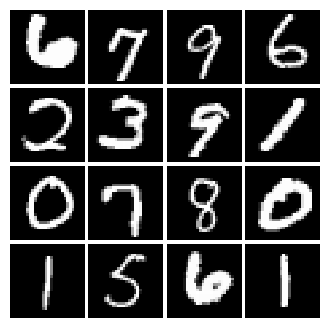

Target


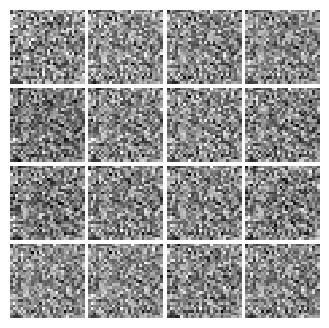


Iter: 250.0, D: 1.257, G:1.587, C:0.1907

 Source


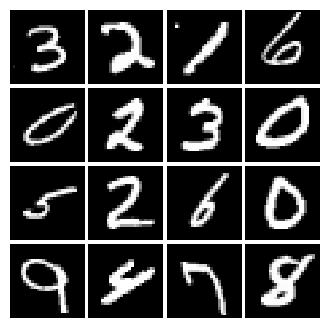

Target


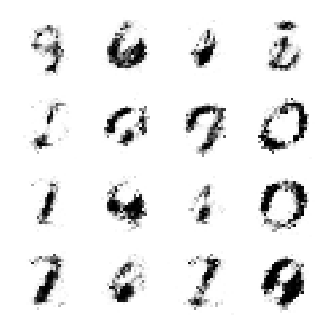


Iter: 500.0, D: 1.261, G:1.015, C:0.1475

 Source


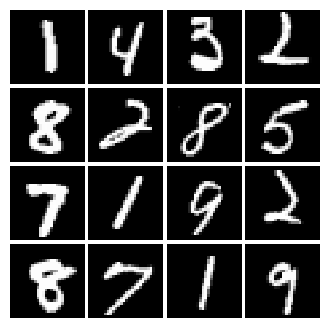

Target


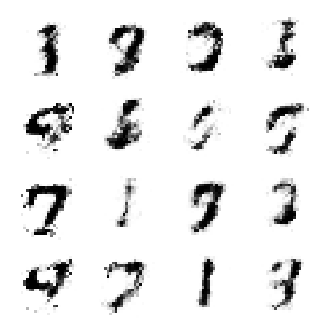


Iter: 750.0, D: 1.332, G:1.078, C:0.1325

 Source


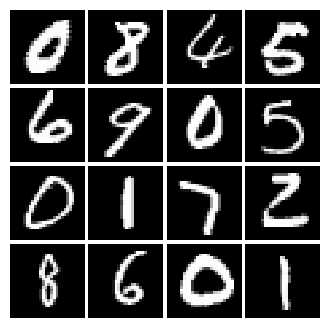

Target


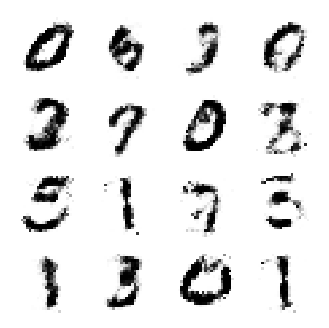


Iter: 1000.0, D: 1.152, G:1.325, C:0.1277

 Source


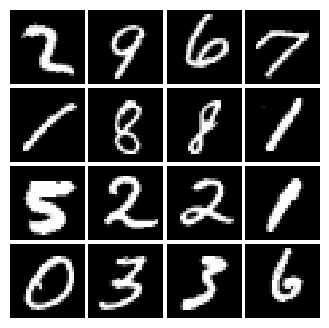

Target


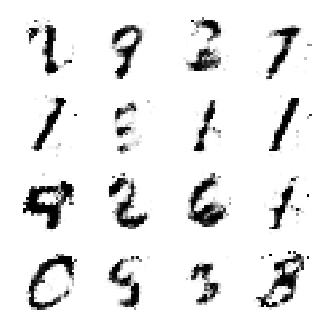


Iter: 1250.0, D: 1.148, G:1.101, C:0.1101

 Source


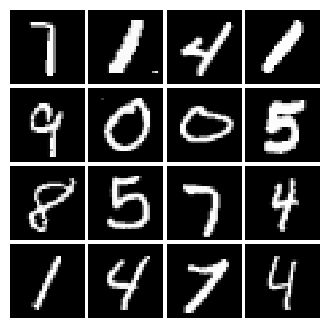

Target


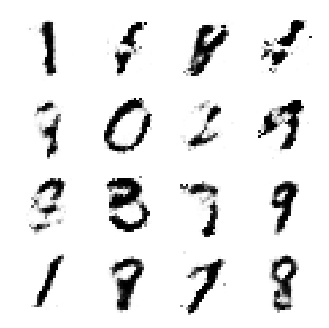


Iter: 1500.0, D: 1.315, G:0.9395, C:0.1106

 Source


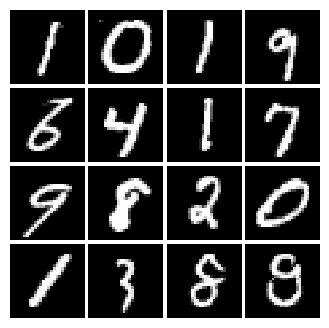

Target


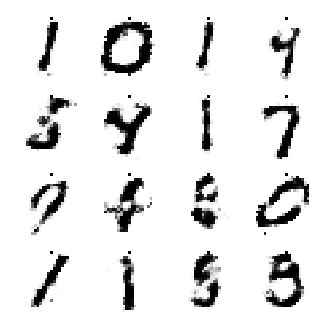


Iter: 1750.0, D: 1.075, G:1.143, C:0.1053

 Source


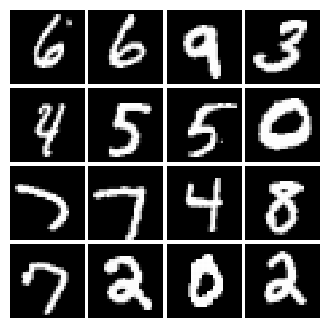

Target


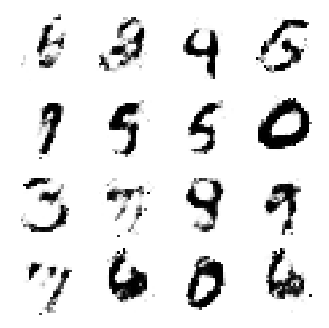


Iter: 2000.0, D: 1.123, G:1.173, C:0.09731

 Source


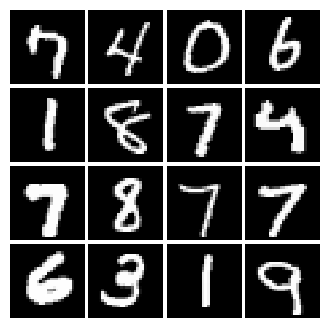

Target


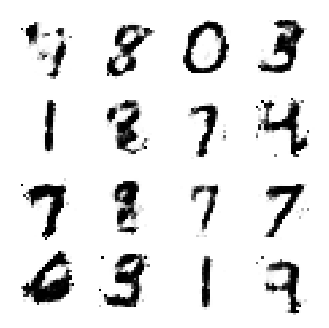


Iter: 2250.0, D: 1.032, G:1.229, C:0.09586

 Source


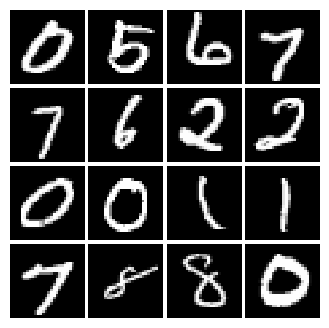

Target


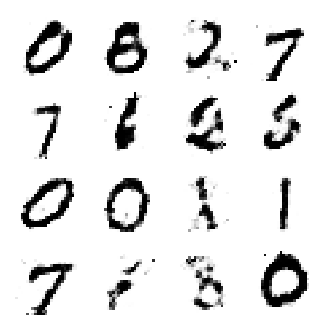


Iter: 2500.0, D: 1.023, G:1.255, C:0.09298

 Source


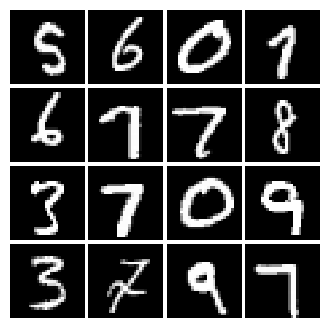

Target


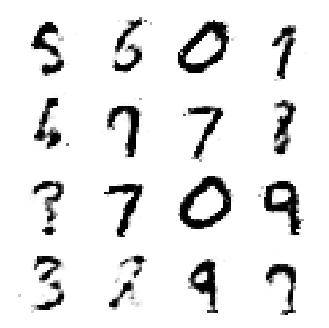


Iter: 2750.0, D: 0.03, G:4.739, C:0.1239

 Source


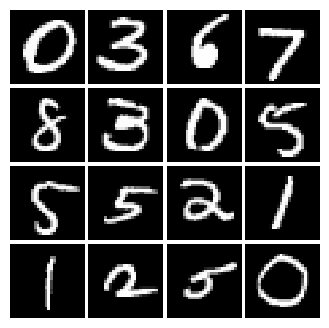

Target


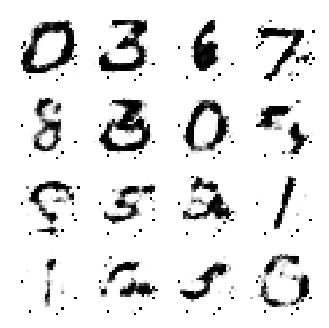


Iter: 3000.0, D: 1.056, G:1.595, C:0.1097

 Source


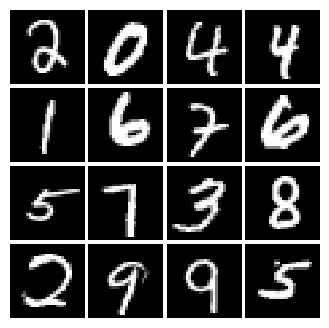

Target


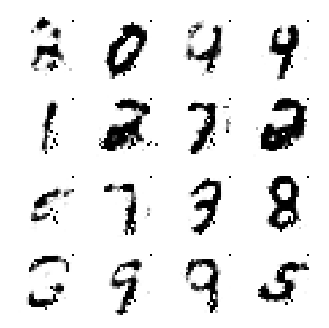


Iter: 3250.0, D: 0.1673, G:8.076, C:0.1602

 Source


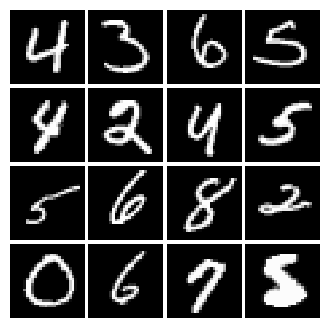

Target


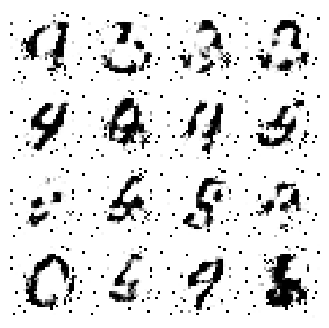


Iter: 3500.0, D: 1.272, G:0.9957, C:0.07955

 Source


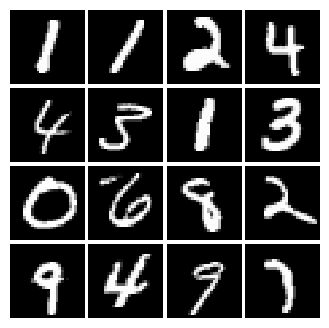

Target


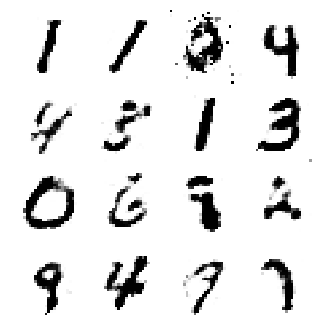


Iter: 3750.0, D: 1.335, G:0.7391, C:0.07229

 Source


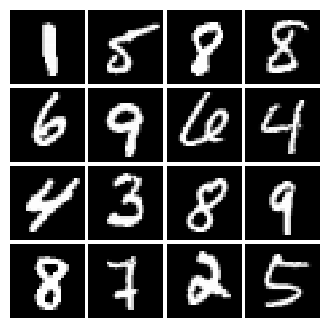

Target


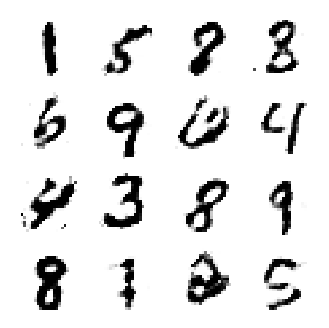


Iter: 4000.0, D: 1.331, G:0.7427, C:0.07484

 Source


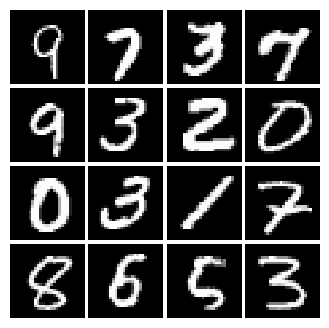

Target


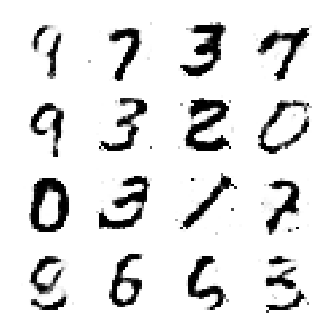


Iter: 4250.0, D: 1.272, G:0.8093, C:0.06877

 Source


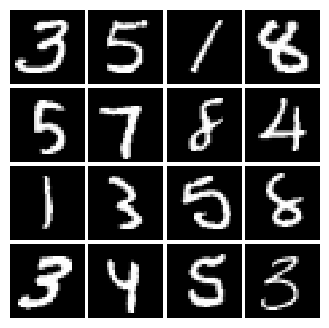

Target


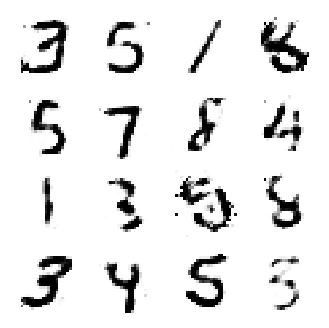


Iter: 4500.0, D: 1.288, G:0.8796, C:0.06743

 Source


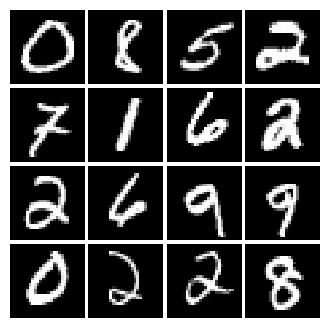

Target


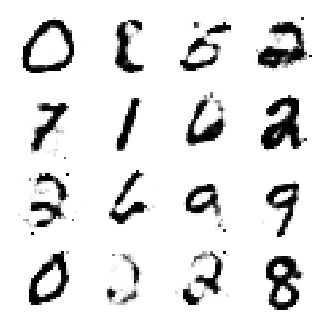

In [ ]:
# Please do not modify anything in this cell

set_seed(0)

# Make the discriminator
D = discriminator().to(device)

# Make the generators
G_A2B = generator().to(device)
G_B2A = generator().to(device)


# Create optimizers for the Discriminator and the Generators
D_solver = optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_solver = optim.Adam(G_A2B.parameters(), lr=1e-3, betas=(0.5, 0.999))
C_solver = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=1e-3, betas=(0.5, 0.999))

# Run it!
run_cycle_gan(D, G_A2B, G_B2A, D_solver, G_solver, C_solver, discriminator_loss, generator_loss, cycle_loss)

Now answer the following questions based on the results.

## Question 1

What is the range of final discriminator error displayed in the cell? (choose the closest answer)

a) 0-0.99 \\
b) 1-1.99 \\
c) 2-2.99 \\
d) 3-3.99

## Question 2

What is the range of final generator error displayed in the cell? (choose the closest answer)

a) 0-0.99 \\
b) 1-1.99 \\
c) 2-2.99 \\
d) 3-3.99

**SRGAN**
In this question we will calculate the content loss used in SRGAN as shown below.

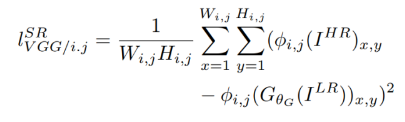

As shown in the equation $\phi(.)$ is the output of intermediate layers of the VGG 16 model. We implement this loss as follows.

We first create a class Model which will return the intermediate feature maps of the VGG 16.

Step 1: We first create a list of pretrained vgg16 'features' block and store it in the variable 'features'. (Hint: Look into torchvision.models.vgg16. Also print the vgg16 model and notice that 'features' block of vgg 16)

Step 2: We next create a module list of the list 'features' (from step 1) and store it in the vairable 'self.features'. (Hint: Look into nn.ModuleList())

Step 3: In the forward function, write a simple for loop that will send the output of the previous module as input to the next module. (Hint: look into enumerate() function. Use the following, enumerate(self.features) to get the idx and module from self.features.) Store the ID of the each module you get from enumerate function as 'idx' as it will be used in the consequent parts of the code.


In [ ]:
import torch
from torchvision import models
import torch.nn as nn

class Model(nn.Module):
  def __init__(self,layer_num):
    super(Model, self).__init__()
    self.layer_num = layer_num
    ## YOUR CODE STARTS HERE ##
    features = models.vgg16(pretrained=True)
    self.features = nn.ModuleList(features.features[: (layer_num + 1)])
    ## YOUR CODE ENDS HERE ##

  def forward(self,x):
    ##YOUR CODE STARTS HERE ##
    for idx,m in enumerate(self.features):
      x = m(x)
    ## YOUR CODE ENDS HERE ##
      if idx == self.layer_num:
        return x


In the below code snippet we will define the content loss function

Step 1: Send the lr tensor as input to the model and store the output in the variable 'lr_feat'.

Step 2: Send the hr tensor as input to the model and store the output in the variable 'hr_feat'.

Step 3: Create an object of MSELoss and store it in the variable 'mse'. (Hint: Look as nn.MSELoss())

Step 4: Calculate MSE loss between lr_feat and hr_feat and save it in the variable loss.

In [ ]:
def content_loss(lr,hr,model):
  ## YOUR CODE STARTS HERE ##
  lr_feat = model(lr)
  hr_feat = model(hr)
  mse = nn.MSELoss()
  loss = mse(lr_feat, hr_feat)
  ## YOUR CODE ENDS HERE ##
  return loss

In [ ]:
torch.manual_seed(0)
lr = torch.rand((1,3,224,224))
hr = torch.rand((1,3,224,224))
model = Model(20)

c_loss = content_loss(lr,hr,model)
print("Content Loss: "+str(c_loss))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 57.7MB/s]


Content Loss: tensor(0.4334, grad_fn=<MseLossBackward0>)


## Question 3.

What is the value of the content loss from above?

a) 0.333 \\
b) 0.433 \\
c) 0.533 \\
d) 0.633

# Week 12

In [ ]:
# NOTE: Execute this cell in the beginning
# Do not edit this cell

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy import ndimage
import torch.backends.cudnn as cudnn
import os
import argparse

def set_seed(seed):
    """Sets the global seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

#setting the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# loading MNIST dataset
print('==> Preparing data..')

# We first download the train and test datasets
mnist_train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# a dictionary to contain train and test sets
mnist_dataset_sizes = {'train' : mnist_train_dataset.__len__(), 'test' : mnist_test_dataset.__len__()}

#defining the train and test loader
mnist_train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_train_dataset,
                 batch_size=256,
                 shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(
                dataset=mnist_test_dataset,
                batch_size=1,
                shuffle=True)

# a dictionary to contain train and test loaders
mnist_dataloaders = {'train' : mnist_train_loader ,'test' : mnist_test_loader}

==> Preparing data..


In [ ]:
# Defining LeNet Model
# we can use this as MNIST not a very complex dataset to learn on
# LeNet Model definition

""""
You should implement LeNet model with the below configuration. Consider that input images are having a single channel:

1.   Conv layer with 10 output channels and filter size 5
2.   Conv layer with 20 output channels and filter size 5
3.   Dropout layer
4.   Fully connected layer with output size 50
5.   Takes input from step 4 and output 10 dimensions (main class labels) through a fully connected layer
"""

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        """YOUR CODE STARTS HERE"""
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc2_ssl = nn.Linear(50, 10)
        """YOUR CODE ENDS HERE"""

    # network architecture for classification head:
    # conv1 -> maxpool2D-> Relu->conv2->conv2_drop->maxpool2D->Relu->Reshape->fc1->Relu->dropout->fc2,log-sofmax
    def forward(self, x):
        """YOUR CODE STARTS HERE"""
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        # classification head
        out_cls = self.fc2(x)
        #apply log_softmax on the output
        return F.log_softmax(x, dim=1)
        """YOUR CODE ENDS HERE"""

In [ ]:
#building model
print('==> Building the LeNet model')
mnist_model = LeNet().to(device)
#defining the loss function
mnist_criterion = nn.CrossEntropyLoss()
#setting the optimizer and number of training epochs
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)
mnist_num_epochs= 20

==> Building the LeNet model


In [ ]:
#Training LeNet model
def train_mnist_model(model, data_loaders, dataset_sizes, criterion, optimizer, num_epochs, device):

    model = model.to(device)
    # set train mode
    model.train()

    # for each epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        running_loss, running_corrects = 0.0, 0

        # for each batch
        for inputs, labels in data_loaders['train']:
            inputs = inputs.to(device)
            labels =labels.to(device)

            """YOUR CODE STARTS HERE"""

            # set optimizer gradient as 0
            optimizer.zero_grad()

            # get the model output
            outputs = model(inputs)

            # get the prediction of model by using argmax or max
            _, preds = torch.max(outputs, 1)

            # calculate loss of the output
            loss = criterion(outputs, labels)

            # backpropagate the loss
            loss.backward()

            # update model parameters using optimzier
            optimizer.step()

            """YOUR CODE ENDS HERE"""

            # calculate total loss of the batch
            batch_loss_total = loss.item() * inputs.size(0)

            # cumluative sum of loss
            running_loss += batch_loss_total

            # cumulative sum of correct count
            running_corrects += torch.sum(preds == labels.data)


        #calculating the loss and accuracy for the epoch
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print('-' * 10)


    # model evaluation
    else:
        model.eval()
        running_loss, running_corrects = 0.0, 0

        # for each batch
        for inputs, labels in data_loaders['test']:
            inputs = inputs.to(device)
            labels =labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)


            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        #calculating the loss and accuracy
        test_loss = running_loss / dataset_sizes['test']
        test_acc = (running_corrects.double() / dataset_sizes['test']).item()
        print('<Test Loss: {:.4f} Acc: {:.4f}>'.format(test_loss, test_acc))

#training LeNet on the MNIST dataset
train_mnist_model(mnist_model, mnist_dataloaders, mnist_dataset_sizes, mnist_criterion, mnist_optimizer, mnist_num_epochs, device)

Epoch 1/20
Train Loss: 2.6354 Acc: 0.4093
----------
Epoch 2/20
Train Loss: 2.2252 Acc: 0.5075
----------
Epoch 3/20
Train Loss: 2.1785 Acc: 0.5146
----------
Epoch 4/20
Train Loss: 2.1541 Acc: 0.5176
----------
Epoch 5/20
Train Loss: 2.1196 Acc: 0.5235
----------
Epoch 6/20
Train Loss: 2.1018 Acc: 0.5266
----------
Epoch 7/20
Train Loss: 2.0892 Acc: 0.5298
----------
Epoch 8/20
Train Loss: 2.0898 Acc: 0.5276
----------
Epoch 9/20
Train Loss: 2.0953 Acc: 0.5268
----------
Epoch 10/20
Train Loss: 2.0959 Acc: 0.5248
----------
Epoch 11/20
Train Loss: 2.0761 Acc: 0.5297
----------
Epoch 12/20
Train Loss: 2.0799 Acc: 0.5284
----------
Epoch 13/20
Train Loss: 2.0668 Acc: 0.5313
----------
Epoch 14/20
Train Loss: 2.0534 Acc: 0.5347
----------
Epoch 15/20
Train Loss: 2.0387 Acc: 0.5365
----------
Epoch 16/20
Train Loss: 2.0559 Acc: 0.5334
----------
Epoch 17/20
Train Loss: 2.0562 Acc: 0.5311
----------
Epoch 18/20
Train Loss: 2.0545 Acc: 0.5324
----------
Epoch 19/20
Train Loss: 2.0506 Acc: 0

In [ ]:
# Save the trained LeNet Model
print('==> Saving model for MNIST..')
torch.save(mnist_model.state_dict(), 'lenet_mnist_model.pth')

#load your pretrained model
print('==> Loading saved model for MNIST..')
mnist_model = LeNet().to(device)
mnist_model.load_state_dict(torch.load('lenet_mnist_model.pth'))
mnist_model.eval()

==> Saving model for MNIST..
==> Loading saved model for MNIST..


LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (fc2_ssl): Linear(in_features=50, out_features=10, bias=True)
)

**Fast Gradient Singed Method attack (FGSM)** \\
In this part, you will implement the FGSM attack, a white box attack. This concept was covered in the Adversarial Robustness lectures.

In [ ]:
# Fast Gradient Singed Method attack (FGSM)

#Inputs:
# Model is the trained model for the target dataset
# target is the ground truth label of the image
# epsilon is the hyper parameter which shows the degree of perturbation

def fgsm_attack(model, image, target, epsilon):

    """YOUR CODE STARTS HERE"""

    # Set requires_grad attribute of tensor.
    # This is necessary for the attack
    image.requires_grad = True

    # Forward pass the data through the model
    output = model(image)

    # get the index of the max log-probability which is basically the prediction of the model
    init_pred = output.max(1, keepdim=True)[1]

    # If the initial prediction is wrong, an attack is not required
    # return the image
    if init_pred[0].item() != target[0].item():
        return image

    # Calculate the nll loss
    # Hint: you will find it in the pytorch library
    loss = F.nll_loss(output, target)

    # Zero all existing gradients
    #i.e do model.zero_grad()
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect gradient data
    data_grad = image.grad.data

    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    #recall the formula for FGSM attack
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    """YOUR CODE ENDS HERE"""


    # Return the perturbed image
    return perturbed_image

In [ ]:
## Please DONOT remove these lines.
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

q = torch.rand(1, 28, 28).to(device)
## Please DONOT remove these lines.

### YOUR CODE STARTS HERE ###

#set target=1
target = torch.tensor([1]).to(device)

#call the fgsm_attack function with mnist_model, q, target and epsilon=0.3 as input parameters
perturbed_data = fgsm_attack(mnist_model, q, target, epsilon=0.3)

#print the mean value of the above resultant tensor
torch.mean(perturbed_data)

### YOUR CODE ENDS HERE ###


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


tensor(0.4986, device='cuda:0', grad_fn=<MeanBackward0>)

### Question 4:

What is the range of the mean value of the perturbed data?


a) 0.05 - 0.1 \\
b) 0.15 - 0.25 \\
c) 0.3 - 0.5 \\
d) 0.7 - 0.9



**Self-supervised Learning**


In this section, the task is to implement the rotation-based self-supervised task. We will use the previously implemented LeNet model (with slight modification) and the MNIST dataset.

In this specific case, our model has two heads - one head for the main classification (10 classes, in MNIST), and another head for the rotation prediction (4 rotations). The second head performs self-supervised learning here.

You should implement a model with the below configuration. Consider that input images are having a single channel:

1.   Conv layer with 10 output channels and filter size 5
2.   Conv layer with 20 output channels and filter size 5
3.   Dropout layer
4.   Fully connected layer with output size 50
5.   Branch out 2 heads, one for the main classification head and one for the   rotation classification heads.

  *   Takes input from step 4 and output 10 dimensions (main class labels) through a fully connected layer
  *   Takes input from step 4 and output 4 dimensions(rotation class labels) through a fully connected layer

**Your task is to implement the above model**. In the implementation, you should **define** these layers, and then define the **forward pass** of the model.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torch.utils.data
import numpy as np


import torchvision
import torchvision.transforms as transforms
torch.manual_seed(1)

# Assumes that tensor is (nchannels, height, width)
# Apply the respective rotations on x based on their function names

def tensor_rot_90(x):

    """YOUR CODE STARTS HERE"""
    return x.flip(2).transpose(1, 2)
    """YOUR CODE ENDS HERE"""


def tensor_rot_180(x):

    """YOUR CODE STARTS HERE"""
    return x.flip(2).flip(1)
    """YOUR CODE ENDS HERE"""


def tensor_rot_270(x):

    """YOUR CODE STARTS HERE"""
    return x.transpose(1, 2).flip(2)


def rotate_batch_with_labels(batch, labels):
	images = []
	for img, label in zip(batch, labels):
		if label == 1:
			img = tensor_rot_90(img)
		elif label == 2:
			img = tensor_rot_180(img)
		elif label == 3:
			img = tensor_rot_270(img)
		images.append(img.unsqueeze(0))
	return torch.cat(images)



def rotate_batch(batch, label):
	if label == 'rand':
		labels = torch.randint(4, (len(batch),), dtype=torch.long)
	elif label == 'expand':
		labels = torch.cat([torch.zeros(len(batch), dtype=torch.long),
					torch.zeros(len(batch), dtype=torch.long) + 1,
					torch.zeros(len(batch), dtype=torch.long) + 2,
					torch.zeros(len(batch), dtype=torch.long) + 3])
		batch = batch.repeat((4,1,1,1))
	else:
		assert isinstance(label, int)
		labels = torch.zeros((len(batch),), dtype=torch.long) + label
	return rotate_batch_with_labels(batch, labels), labels

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        """YOUR CODE STARTS HERE"""
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc2_ssl = nn.Linear(50, 4)
        """YOUR CODE ENDS HERE"""

    # network architecture for classification head:
    # conv1 -> maxpool2D-> Relu->conv2->conv2_drop->maxpool2D->Relu->Reshape->fc1->Relu->dropout->fc2,fc2_ssl
    def forward(self, x):
        """YOUR CODE STARTS HERE"""
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        # classification head
        out_cls = self.fc2(x)
        # self supervised head
        out_ssl = self.fc2_ssl(x)
        """YOUR CODE ENDS HERE"""
        return out_cls, out_ssl

# MNIST Test dataset and dataloader declaration
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

# the datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# Initialize the network
net = Net().to(device)

parameters = list(net.parameters())
optimizer = optim.SGD(parameters, lr=0.1, momentum=0.9, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss().to(device)
print('Running...')

def train(epoch):
    net.train()

    for batch_idx, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)
        labels_full = labels.repeat(4)

        ## Self supervised head
        inputs_ssh, labels_ssh = rotate_batch(inputs, "expand")
        inputs_ssh, labels_ssh = inputs_ssh.to(device), labels_ssh.to(device)
        # outputs_clh , outputs_ssh denotes classification head output and self supervision head output respectively
        outputs_clh, outputs_ssh = net(inputs_ssh)
        loss = criterion(outputs_clh, labels_full)
        loss_ssh = criterion(outputs_ssh, labels_ssh)
        loss += loss_ssh

        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
          print(('Epoch: [%d]; Iter: [%d/%d]; Loss: %f' %(epoch,batch_idx, len(trainloader),loss.item())))


## Funtion to compute test accuracy using model already trained with additional self-supervised head..
def test():
        net.eval()
        net.to(device)
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs,_ = net(inputs)
                # loss = criterion(outputs, targets)

                # test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        acc = 100.*correct/total
        print('Test Accuracy: %f' %(acc))

CUDA Available:  True
Running...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Let us train the network for 1 epoch

set_seed(0)

for epoch in range(0, 1):
  train(epoch)

Epoch: [0]; Iter: [0/469]; Loss: 3.755764
Epoch: [0]; Iter: [50/469]; Loss: 2.295209
Epoch: [0]; Iter: [100/469]; Loss: 1.928455
Epoch: [0]; Iter: [150/469]; Loss: 2.109364
Epoch: [0]; Iter: [200/469]; Loss: 1.649168
Epoch: [0]; Iter: [250/469]; Loss: 1.559747
Epoch: [0]; Iter: [300/469]; Loss: 1.496619
Epoch: [0]; Iter: [350/469]; Loss: 1.452908
Epoch: [0]; Iter: [400/469]; Loss: 1.331284
Epoch: [0]; Iter: [450/469]; Loss: 1.439482


In [ ]:
test()

Test Accuracy: 90.230000


In [ ]:
# The below code will output the logits of the rotation head of the classifier.
# Execute it and answer the question below

net.eval()
net.to(device)
test_loss, correct, total = 0, 0, 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        break

input = inputs[2:3]
target = targets[2:3]

outputs_cl,outputs_ssh = net(input)

print(math.floor(int(torch.mean(torch.sum(outputs_ssh.data) + torch.sum(outputs_cl.data)))))

1


### Question 5:

Follow the steps and mark the answer: \\
1) Add the values in the ssl output tensor. \\
2) Add the values in the cl output tensor. \\
3) Add the above two values. \\
4) Report the closest number to the result as your answer. \\

a) 0.15 \\
b) 1.35 \\
c) 3.43 \\
d) 2.34

Contrastive Loss for SSL
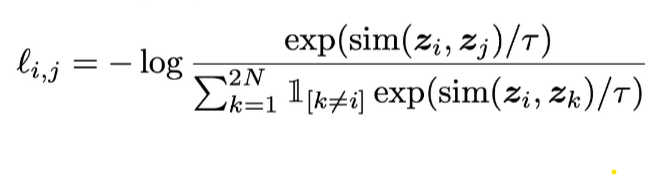

As seen from the above equation, contrastive loss works by bringing the positive pair (z_i,z_j) closer to each other with the help of a similarity function (Eg. Cosine Similarity). In this question we will create a matrix version of this loss function for fast implementation using Pytorch.

We will use two vectors x1 and x2 corresponding to two augmented views, defined as shown below. These can be considered as the embedding vectors. Lets consider two images A and B that undergo two types of augmentation to generate A1, B1 and A2,B2 respectively. The vector x1 consists of the embeddings of A1 and B1, similarly vector x2 consists of the embeddings of A2 and B2. Using contrastive loss we want all positive pairs i.e (A1,A2), (B1,B2), (A2,A1), and (B2,B1) to come closer. Follow the below steps to complete this question.

Step 1: Concatenate x1 and x2 along the dimension 0 and store it in variable 'batch'.

Step 2: Concatenate labels1 and labels2 along the dimension 0 and store it in the variable 'labels'.

Step 3: Normalize each embedding vector across the dimension 1 in the concatenated vector batch and store it in the variable 'batch_norm'.

Step 4: Compute the matrix multiplication between batch_norm and its transpose and divide it with variable 't' and save it in the new variable 'sim_matrix'. (Hint: Look into the operation '@' and '.T' )




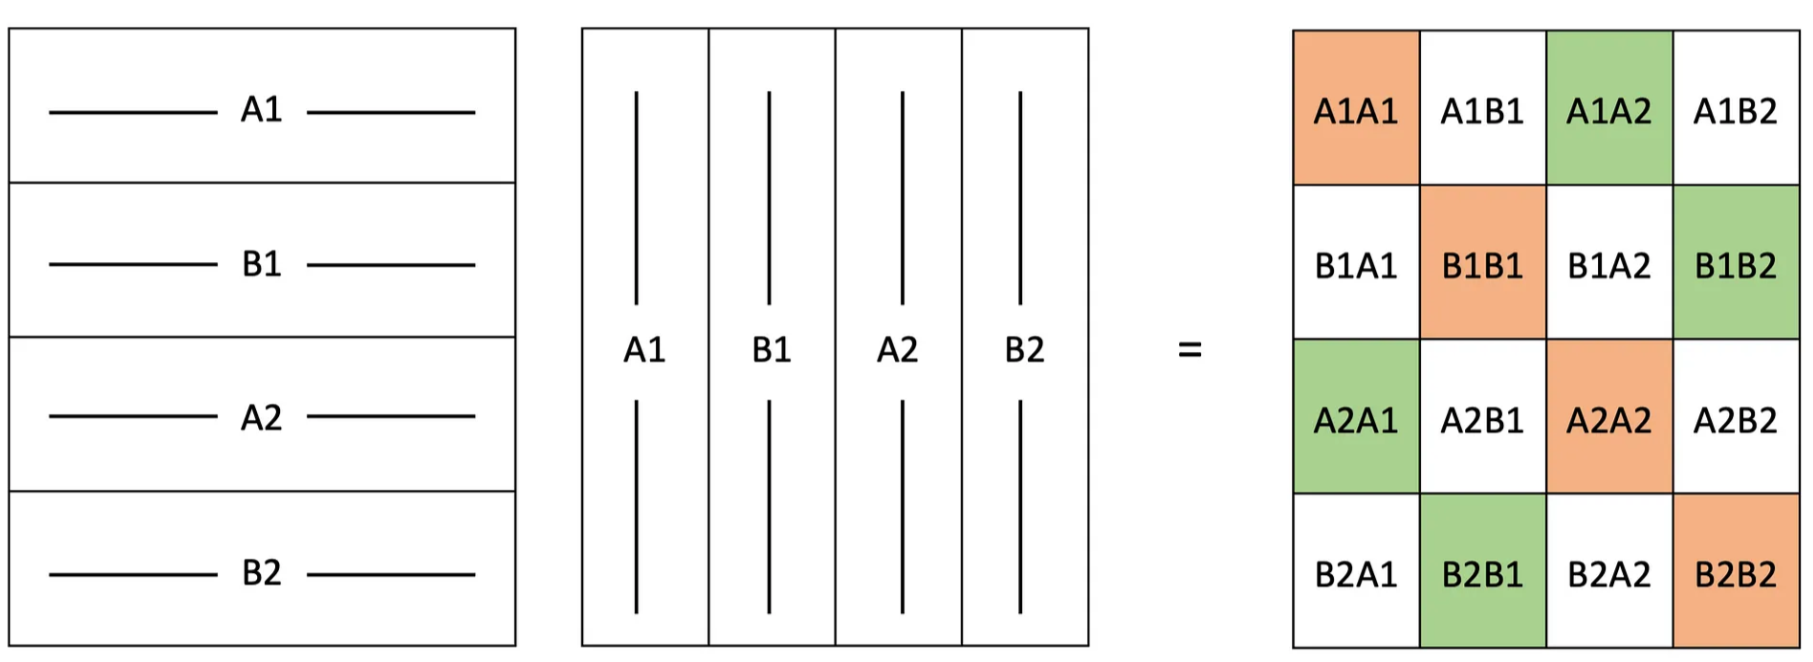

Step 5: Calculate the elementwise exponential value of sim_matrix and store it in the variable 'sim_matrix'.

Step 6: Next we generate masks to select the positive pair elements as follows.
  

As seen from the above the sim_matrix will have similarity scores of all the pairwise combinations. We are interested only in the positive pairs (in green color) and we should also remove the orange color pairs from the denominator calculation of the loss function as, k $\neq$ i, from the equation shown in the start. To get the green color pairs, we generate the masks as follows.

We use the variables l1 and l0 which are of the shape (4,1) and (1,4) respectively. We find the elementwise equality between l1 and l0 and store it in the variable 'mask'.(Hint: Look into 'torch.eq()')

Step 7: We then subtract the identity matrix of shape (4,4) from the mask matrix and store it in the variable 'mask'.

Step 8: Multiply sim_matrix with mask and find the sum along the dimension '-1' and store it in the variable 'n'.

Step 9: Subtract the diagonal elements of the sim_matrix from the  sim_matrix summed along the dimension '-1'  and store it in the variable 'd'. (Hint: look at 'torch.diag()')

Step 10: Calculate the negative log of the fraction 'n/d' and store it in the variable 'loss'.

In [ ]:
import torch
import torch.nn.functional as F

torch.manual_seed(0)

x1 = torch.randn((2,5))

labels1 = torch.tensor([0, 1])

x2 = torch.randn((2,5))

labels2 = torch.tensor([0, 1])

t = 0.07

## YOUR CODE STARTS HERE ##

batch = torch.cat((x1, x2), dim=0)
labels = torch.cat((labels1, labels2), dim=0)
batch_norm = F.normalize(batch)

sim_matrix = torch.matmul(batch_norm, batch_norm.t())
sim_matrix = sim_matrix / t

l1 = labels.unsqueeze(1)
l0 = labels.unsqueeze(0)

mask = (l1 == l0)
mask = mask.float()  # Use logical_not() to invert the mask

n = mask.sum(dim=-1)
d = mask.sum(dim=-1)


loss = sim_matrix * mask

## YOUR CODE ENDS HERE ##

print("Mean loss value: "+str(loss.mean()))

Mean loss value: tensor(5.0301)


### Question 6:

What is mean of the loss value printed above?

a) 0.016 \\
b) 0.017 \\
c) 0.018 \\
d) 0.019